# Import Modules and Data

In [10]:
from glob import glob
import geopandas as gp
import numpy as np
import pandas as pd
import pickle
import random
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.model_selection import ParameterGrid
import os

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 100

try:
    if kernel_is_loaded:
        pass
except:
    os.chdir('/'.join(os.getcwd().split('/')[:-1]))
    kernel_is_loaded = True

In [11]:
train = pd.read_csv(r'data/train-4.csv')
test = pd.read_csv(r'data/test-4.csv')
val = pd.read_csv(r'data/val-4.csv')

# Seeding

In [12]:
def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything()

# Predictor and label split

In [13]:
X_train = train.drop('crop_name', axis=1)
y_train = train['crop_name']

X_val = val.drop('crop_name', axis=1)
y_val = val['crop_name']

X_test = test.drop('crop_name', axis=1)
y_test = test['crop_name']

# Scaling

In [14]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

pickle.dump(scaler, open(r'models/standard_scaler.pkl', 'wb'))

# Building conformal prediction algorithm

In [15]:
class _conformal_prediction:
    def __init__(self, estimator):
        self.estimator = estimator
        self.quantile = None
        self.coverage = None
    def fit(self, X_cal, y_cal, alpha):
        cal_pred_proba = self.estimator.predict_proba(X_cal)
        scores = 1 - cal_pred_proba
        true_class_scores = list(map(lambda row, idx:row[idx], scores, y_cal))
        n = X_cal.shape[0]
        self.coverage = (n+1)*(1 - alpha)/n
        self.quantile = np.quantile(true_class_scores, self.coverage)
    def predict(self, X_test):
        test_pred_proba = self.estimator.predict_proba(X_test)
        scores = 1 - test_pred_proba
        def func(crop):
            crop_set = (crop <= self.quantile).nonzero()[0]
            if len(crop_set) == 0:
                return np.nan
            else:
                return ' '.join(list(map(str, crop_set)))
        pred_set = list(map(func, scores))
        return test_pred_proba, pred_set

# Modelling

In [16]:
fort_nights = list(X_train.loc[:, 'oct_2f':'apr_1f'].columns)

params = {'n_estimators':np.arange(5,100,5), 'learning_rate':np.arange(0.05, 0.55, 0.05), 
          'max_depth':np.arange(1,5,1)}

# sample_weights = compute_sample_weight(class_weight='balanced',y=y_train)

param_grid = list(ParameterGrid(params))
max_precision_scores = []
best_params = []
fns_used = []

i = 0

while (i + 4) <= len(fort_nights):
    precision_scores = []
    if i == 0:
        drop_cols = []
    else:
        drop_cols = fort_nights[-i:]
    for p in param_grid:
        wheat_classifier = XGBClassifier(**p)
        temp_X_train = X_train.drop(drop_cols, axis=1)
        temp_X_val = X_val.drop(drop_cols, axis=1)
        wheat_classifier.fit(temp_X_train, y_train)
        val_pred = wheat_classifier.predict(temp_X_val)
        precision, recall, f1score, support = score(y_val, val_pred, labels=[0,1])
        precision_scores.append(precision)
        
    precision_scores = np.array(precision_scores)
    max_must_idx = np.argmax(precision_scores, axis=0)[0]
    max_precision_scores.append(precision_scores[max_must_idx])
    best_params.append(param_grid[max_must_idx])

    fns_used.append('-'.join(temp_X_train.columns[[0,-1]]))
    print(len(drop_cols), 'dropped', 'completed')
    
    i += 1
    
print('Done!!')

0 dropped completed
1 dropped completed
2 dropped completed
3 dropped completed
4 dropped completed
5 dropped completed
6 dropped completed
7 dropped completed
8 dropped completed
Done!!


In [17]:
max_precision_scores

[array([0.98023715, 0.98983051]),
 array([0.97647059, 0.9914966 ]),
 array([0.98031496, 0.99151104]),
 array([0.97233202, 0.98644068]),
 array([0.97188755, 0.97979798]),
 array([0.97580645, 0.97983193]),
 array([0.97580645, 0.97983193]),
 array([0.96326531, 0.96989967]),
 array([0.95762712, 0.9538715 ])]

In [18]:
test_reports = []
test_precision_scores = []
confusion_matrices = []
test_dfs = []
best_models = []

for i in range(len(fns_used)):
    best_classifier = XGBClassifier(**best_params[i])
    
    strt_fn, end_fn = fns_used[i].split('-')
    temp_X_train = X_train.loc[:, strt_fn:end_fn]
    temp_X_test = X_test.loc[:, strt_fn:end_fn]
    best_classifier.fit(temp_X_train, y_train)
    best_models.append(best_classifier)
#     pickle.dump(best_classifier, open(r'models/XGB_Binary_sowing-nov1f_{}_1.1'.format('-'.join(temp_X_train.columns[[0,-1]])), 'wb'))
    test_pred = best_classifier.predict(temp_X_test)
    report = classification_report(y_test, test_pred, target_names=['Mustard', 'Wheat'], output_dict=True)
    df = pd.DataFrame(report).transpose().loc[:'Wheat',:'f1-score']
    test_reports.append(df)
    test_precision_scores.append(df['precision'].values)
    print(fns_used[i])
    display(test_reports[i])
    # cf = pd.crosstab(y_test, pd.Series(test_pred, name='pred')).rename({0:'Non_wheat', 1:'Wheat'}).rename({0:'Non_wheat', 1:'Wheat'}, axis=1)
    # confusion_matrices.append(cf)
    # df1 = pd.DataFrame(data = {'GT':confusion_matrices[-1].sum(axis=1),
    #                                 'correct_pred':np.diag(confusion_matrices[-1])})
    # df1['correct_pred(%)'] = round(df1['correct_pred']/df1['GT']*100, 2)
    # temp_df = deepcopy(confusion_matrices[-1])
    # np.fill_diagonal(temp_df.values, 0)
    # temp_df.columns = ['incorr_pred_must', 'incorrect_pred_wh']
    # df1 = pd.concat([df1, temp_df], axis=1)
    # test_dfs.append(df1)

oct_2f-apr_1f


,precision,recall,f1-score
Mustard,0.540644,0.995763,0.700795
Wheat,0.999419,0.896007,0.944892


oct_2f-mar_2f


,precision,recall,f1-score
Mustard,0.597623,0.994350,0.746554
Wheat,0.999244,0.917708,0.956742


oct_2f-mar_1f


,precision,recall,f1-score
Mustard,0.615048,0.992938,0.759589
Wheat,0.999061,0.923611,0.959856


oct_2f-feb_2f


,precision,recall,f1-score
Mustard,0.750533,0.994350,0.855407
Wheat,0.999277,0.959375,0.978919


oct_2f-feb_1f


,precision,recall,f1-score
Mustard,0.875312,0.991525,0.929801
Wheat,0.998941,0.982639,0.990723


oct_2f-jan_2f


,precision,recall,f1-score
Mustard,0.856622,0.995763,0.920967
Wheat,0.999469,0.979514,0.989391


oct_2f-jan_1f


,precision,recall,f1-score
Mustard,0.801596,0.992938,0.887066
Wheat,0.999106,0.969792,0.984230


oct_2f-dec_2f


,precision,recall,f1-score
Mustard,0.620141,0.991525,0.763043
Wheat,0.998876,0.925347,0.960707


oct_2f-dec_1f


,precision,recall,f1-score
Mustard,0.464883,0.981638,0.630958
Wheat,0.997386,0.861111,0.924252


In [22]:
display(test_reports[4]) # best score

pickle.dump(best_models[4], open(r'models/wheat_vs_mustard.pkl', 'wb')) # best model pickling

,precision,recall,f1-score
Mustard,0.875312,0.991525,0.929801
Wheat,0.998941,0.982639,0.990723


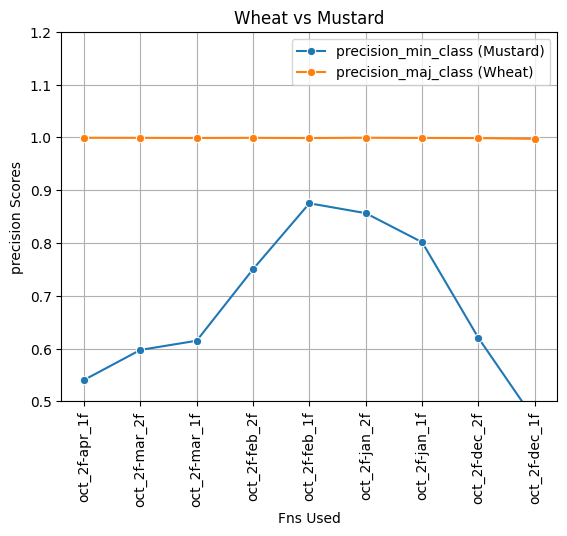

In [34]:
sns.lineplot(y=np.array(test_precision_scores)[:,0], x=fns_used, label='precision_min_class (Mustard)', marker="o")
sns.lineplot(y=np.array(test_precision_scores)[:,1], x=fns_used, label='precision_maj_class (Wheat)', marker="o")
plt.xlabel('Fns Used')
plt.ylabel('precision Scores')
plt.xticks(rotation='vertical')
plt.title('Wheat vs Mustard')
plt.ylim([0.5,1.2])
plt.grid()
plt.show()

In [35]:
plt.figure(figsize=(15,30))

for i in range(len(confusion_matrices)):
    plt.subplot(5,2,i+1)
    sns.heatmap(confusion_matrices[i], annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class/GT')
    plt.title(f'Fns Used: [{fns_used[i]}]')
plt.show()

<Figure size 1500x3000 with 0 Axes>

# Conformal Predictions on unlabelled dataset using the best model

In [36]:
# Will be using the best model to get set predictions
print('fns_used:', fns_used[4])
display(best_models[4])

fns_used: oct_2f-feb_1f


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [37]:
best_model_dict = {}

for i in range(len(fns_used)):
    best_model_dict[fns_used[i]] = best_models[i]

In [38]:
unlabelled = pd.read_csv(r'data_files/data_share/cleaned_others.csv')

unlabelled.head(3)

# Scaling
scaled_unlabelled = pd.DataFrame(data = scaler.transform(unlabelled), columns = unlabelled.columns)

In [39]:
# our best_model was built with NDVI bands from oct_2f to feb_1f
strt_fn, end_fn = 'oct_2f', 'feb_1f'
alpha = 0.05

estimator = best_model_dict[strt_fn+'-'+end_fn]

temp_unlabelled = scaled_unlabelled.loc[:,strt_fn:end_fn]
temp_X_val = X_val.loc[:,strt_fn:end_fn]

cp = _conformal_prediction(estimator)
cp.fit(temp_X_val, y_val, alpha)

pred_prob, set_pred = cp.predict(temp_unlabelled)

unlabelled['max_prob'] = np.max(pred_prob, axis=1)
unlabelled['pred'] = set_pred
# unlabelled['labels'] = np.argmax(pred_prob, axis=1)

unlabelled.pred.value_counts(dropna=False)

pred
1      5136
0      3943
NaN    3842
Name: count, dtype: int64